In [30]:
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8


In [36]:
#dataset = "mendelian_traits_matched_9"
dataset = "mendelian_traits_all"
#dataset = "complex_traits_all"
subset = "all"

#subset = "maf_0.00_0.05"
#subset = "maf_0.05_0.50"
#subset = "maf_0.0_0.1"
#subset = "maf_0.1_0.2"
#subset = "maf_0.2_0.3"
#subset = "maf_0.3_0.4"
#subset = "maf_0.4_0.5"

features = [
    "CADD",
    "GPN-MSA_LLR",
    "GPN-MSA_absLLR",

    "GPN_LLR",
    "GPN_absLLR",
]

base_dir = f"../../results/dataset/{dataset}"
V = pl.read_parquet(f"{base_dir}/test.parquet")
for feature in features:
    df = pl.read_parquet(f"{base_dir}/features/{feature}.parquet")
    df.columns = [f"{feature}_{col}" for col in df.columns]
    V = pl.concat([V, df], how="horizontal")
subset_df = pl.read_parquet(f"{base_dir}/subset/{subset}.parquet")
V = subset_df.join(V, on=["chrom", "pos", "ref", "alt"], how="left")
V

chrom,pos,ref,alt,OMIM,consequence,label,CADD_RawScore,GPN-MSA_LLR_score,GPN-MSA_absLLR_score,GPN_LLR_score,GPN_absLLR_score
str,i64,str,str,str,str,bool,f32,f32,f32,f32,f32
"""1""",13273,"""G""","""C""",null,"""non_coding_transcript_exon_var…",false,0.670358,-4.074219,4.074219,0.2578125,0.2578125
"""1""",14464,"""A""","""T""",null,"""non_coding_transcript_exon_var…",false,-0.020478,0.89502,0.89502,0.235107,0.235107
"""1""",15211,"""T""","""G""",null,"""intron_variant""",false,0.351956,-0.74707,0.74707,-2.019531,2.019531
"""1""",16257,"""G""","""C""",null,"""intron_variant""",false,-0.324504,-0.17627,0.17627,-1.402344,1.402344
"""1""",16487,"""T""","""C""",null,"""intron_variant""",false,0.94002,-3.699219,3.699219,-0.171265,0.171265
…,…,…,…,…,…,…,…,…,…,…,…
"""Y""",22315970,"""T""","""C""",null,"""non_coding_transcript_exon_var…",false,0.282118,-0.430664,0.430664,-0.996582,0.996582
"""Y""",22319145,"""G""","""A""",null,"""intron_variant""",false,-0.213298,2.28125,2.28125,2.4296875,2.4296875
"""Y""",22332256,"""A""","""G""",null,"""non_coding_transcript_exon_var…",false,0.352299,-1.597656,1.597656,-2.197266,2.197266


In [37]:
sorted_V = {
    "CADD": V.sort("CADD_RawScore", descending=True),

    "GPN-MSA": V.sort("GPN-MSA_LLR_score", descending=False),
    "gLM-Promoter": V.sort("GPN_LLR_score", descending=False),

    #"GPN-MSA": V.sort("GPN-MSA_absLLR_score", descending=True),
    #"gLM-Promoter": V.sort("GPN_absLLR_score", descending=True),
}

In [44]:
n_pos = V["label"].sum()
k = n_pos

In [45]:
res = []
for model, df in sorted_V.items():
    n = df.head(k)["label"].sum()
    precision_at_k = n / k
    res.append([
        model,
        k,
        n,
        precision_at_k,
    ])
res = pd.DataFrame(res, columns=["model", "k", "n_pos@k", "precision@k"])
res = res.sort_values("precision@k", ascending=False)
res

,model,k,n_pos@k,precision@k
1,GPN-MSA,339,51,0.150442
0,CADD,339,5,0.014749
2,gLM-Promoter,339,1,0.002950


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


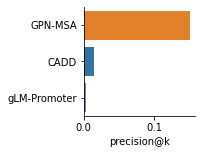

In [46]:
plt.figure(figsize=(2,2))
g = sns.barplot(
    data=res,
    y="model",
    x="precision@k",
    palette=palette,
)
g.set(
    ylabel="",
)
sns.despine();

## Enrichment (similar to GeneticsGym)

In [42]:
res = []
for model, df in sorted_V.items():
    threshold_i = int(0.05 * len(df))
    df_head = df[:threshold_i]
    df_rest = df[threshold_i:]
    n = df_head["label"].sum()
    res.append([
        model,
        n,
    ])
res = pd.DataFrame(res, columns=["model", "n"])
res = res.sort_values("n", ascending=False)
res

,model,n
0,CADD,284
1,GPN-MSA,257
2,gLM-Promoter,90
